# Demo 1: Similarity

c:\Users\edxu0\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded the voice encoder model on cpu in 0.05 seconds.


Preprocessing wavs: 100%|██████████| 120/120 [00:05<00:00, 21.03wavs/s]


Shape of embeddings: (6, 256)


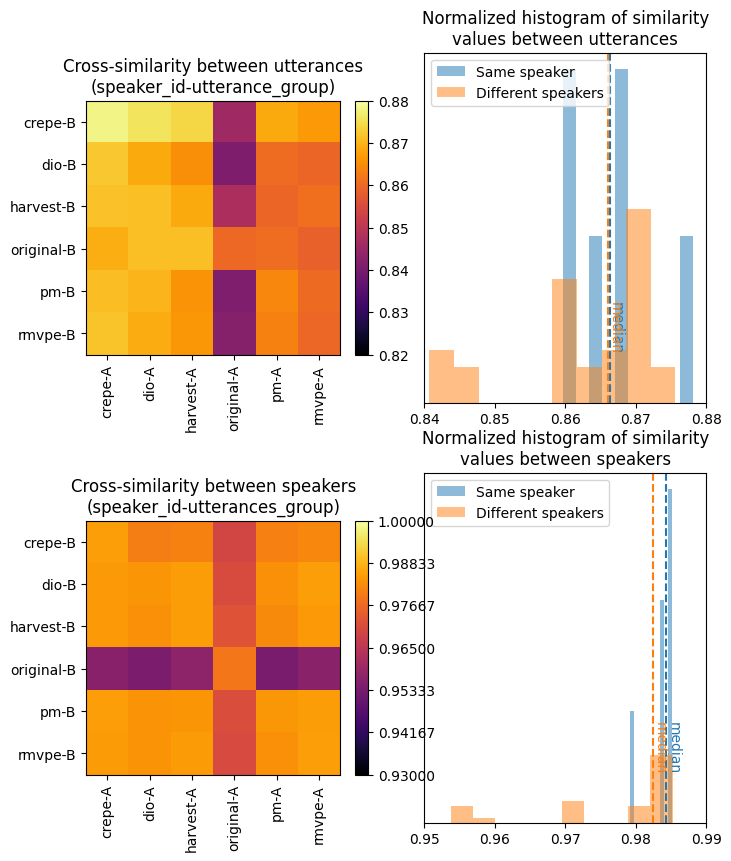

[[0.87809676 0.8756181  0.87392914 0.84569126 0.86872655 0.8665242 ]
 [0.87206376 0.86858237 0.8651151  0.8407171  0.86037266 0.85940105]
 [0.8713585  0.87121034 0.86866117 0.8474338  0.8594307  0.8608082 ]
 [0.86912024 0.8712385  0.87126726 0.8600598  0.8607218  0.85874605]
 [0.8710492  0.86996716 0.86577016 0.8409154  0.86412084 0.86015207]
 [0.8717438  0.86890405 0.8662055  0.84202677 0.86339265 0.8596419 ]]
[0.87809676 0.86858237 0.86866117 0.8600598  0.86412084 0.8596419 ]
[0.8756181  0.87392914 0.84569126 0.86872655 0.8665242  0.87206376
 0.8651151  0.8407171  0.86037266 0.85940105 0.8713585  0.87121034
 0.8474338  0.8594307  0.8608082  0.86912024 0.8712385  0.87126726
 0.8607218  0.85874605 0.8710492  0.86996716 0.86577016 0.8409154
 0.86015207 0.8717438  0.86890405 0.8662055  0.84202677 0.86339265]
[[0.98520803 0.9801289  0.9808016  0.9695518  0.9804026  0.98160416]
 [0.98423296 0.98365635 0.9848148  0.97097397 0.9829111  0.9849841 ]
 [0.9841838  0.9828529  0.98471904 0.9724307

In [1]:
from resemblyzer import preprocess_wav, VoiceEncoder
from demo_utils import *
from itertools import groupby
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


# The demos are ordered so as to make the explanations in the comments consistent. If you only 
# care about running the code, then you don't have to follow that order.
# DEMO 01: we'll show how to compare speech segments (=utterances) between them to get a metric  
# on how similar their voices sound. We expect utterances from the same speaker to have a high 
# similarity, and those from distinct speakers to have a lower one. 


# The neural network will automatically use CUDA if it'speaker available on your machine, otherwise it 
# will use the CPU. You can enforce a device of your choice by passing its name as argument to the 
# constructor. The model might take a few seconds to load with CUDA, but it then executes very 
# quickly.
encoder = VoiceEncoder()

# We'll use a smaller version of the dataset LibriSpeech test-other to run our examples. This 
# smaller dataset contains 10 speakers with 10 utterances each. N.B. "wav" in variable names stands
# for "waveform" and not the wav file extension.
# wav_fpaths = list(Path("audio_data", "librispeech_test-other").glob("**/*.flac"))
wav_fpaths = list(Path("audio_data", "sun").glob("**/*.wav"))
# Group the wavs per speaker and load them using the preprocessing function provided with 
# resemblyzer to load wavs in memory. It normalizes the volume, trims long silences and resamples 
# the wav to the correct sampling rate.
speaker_wavs = {speaker: list(map(preprocess_wav, wav_fpaths)) for speaker, wav_fpaths in
                groupby(tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit="wavs"), 
                        lambda wav_fpath: wav_fpath.parent.stem)}


## Similarity between two utterances from each speaker
# Embed two utterances A and B for each speaker
embeds_a = np.array([encoder.embed_utterance(wavs[0]) for wavs in speaker_wavs.values()])
embeds_b = np.array([encoder.embed_utterance(wavs[1]) for wavs in speaker_wavs.values()])
# Each array is of shape (num_speakers, embed_size) which should be (10, 256) if you haven't 
# changed anything.
print("Shape of embeddings: %s" % str(embeds_a.shape))

# Compute the similarity matrix. The similarity of two embeddings is simply their dot 
# product, because the similarity metric is the cosine similarity and the embeddings are 
# already L2-normed.
# Short version:
utt_sim_matrix = np.inner(embeds_a, embeds_b)
# Long, detailed version:
utt_sim_matrix2 = np.zeros((len(embeds_a), len(embeds_b)))
for i in range(len(embeds_a)):
    for j in range(len(embeds_b)):
        # The @ notation is exactly equivalent to np.dot(embeds_a[i], embeds_b[i])
        utt_sim_matrix2[i, j] = embeds_a[i] @ embeds_b[j]
assert np.allclose(utt_sim_matrix, utt_sim_matrix2)


## Similarity between two speaker embeddings
# Divide the utterances of each speaker in groups of identical size and embed each group as a
# speaker embedding
spk_embeds_a = np.array([encoder.embed_speaker(wavs[:len(wavs) // 2]) \
                         for wavs in speaker_wavs.values()])
spk_embeds_b = np.array([encoder.embed_speaker(wavs[len(wavs) // 2:]) \
                         for wavs in speaker_wavs.values()])
spk_sim_matrix = np.inner(spk_embeds_a, spk_embeds_b)


## Draw the plots
fix, axs = plt.subplots(2, 2, figsize=(8, 10))
labels_a = ["%s-A" % i for i in speaker_wavs.keys()]
labels_b = ["%s-B" % i for i in speaker_wavs.keys()]
mask = np.eye(len(utt_sim_matrix), dtype=bool)
plot_similarity_matrix(utt_sim_matrix, labels_a, labels_b, axs[0, 0],
                       "Cross-similarity between utterances\n(speaker_id-utterance_group)", 0.82, 0.88)
plot_histograms((utt_sim_matrix[mask], utt_sim_matrix[np.logical_not(mask)]), axs[0, 1],
                ["Same speaker", "Different speakers"], 
                "Normalized histogram of similarity\nvalues between utterances", 0.84, 0.88)
plot_similarity_matrix(spk_sim_matrix, labels_a, labels_b, axs[1, 0],
                       "Cross-similarity between speakers\n(speaker_id-utterances_group)", 0.93, 1)
plot_histograms((spk_sim_matrix[mask], spk_sim_matrix[np.logical_not(mask)]), axs[1, 1],
                ["Same speaker", "Different speakers"], 
                "Normalized histogram of similarity\nvalues between speakers", 0.95, 0.99)
plt.show()

"""
print(utt_sim_matrix)

print(spk_sim_matrix)
"""


# Demo 2: Projection

Preprocessing wavs: 100%|██████████| 120/120 [00:02<00:00, 47.87it/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


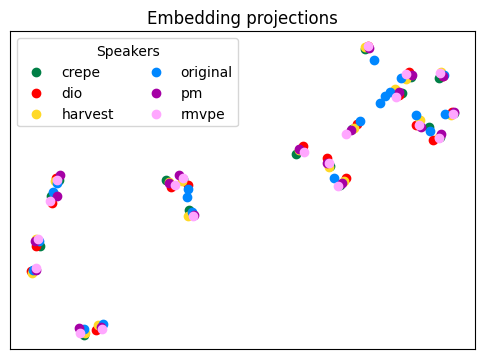

In [2]:

# DEMO 03: we'll show one way to visualize these utterance embeddings. Since they are 
# 256-dimensional, it is much simpler for us to get an overview of their manifold if we reduce 
# their dimensionality first. By doing so, we can observe clusters that form for utterances of 
# identical characteristics. What we'll see is that clusters form for distinct speakers, 
# and they are very tight and even linearly separable.


## Gather the wavs
wav_fpaths = list(Path("audio_data", "sun").glob("**/*.wav"))
speakers = list(map(lambda wav_fpath: wav_fpath.parent.stem, wav_fpaths))
wavs = np.array(list(map(preprocess_wav, tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths)))), dtype=object)
speaker_wavs = {speaker: wavs[list(indices)] for speaker, indices in 
                groupby(range(len(wavs)), lambda i: speakers[i])}


## Compute the embeddings
encoder = VoiceEncoder()
utterance_embeds = np.array(list(map(encoder.embed_utterance, wavs)))


## Project the embeddings in 2D space
plot_projections(utterance_embeds, speakers, title="Embedding projections")
plt.show()


# Demo 3: Fake Detection

Preprocessing wavs: 100%|██████████| 15/15 [00:08<00:00,  1.72 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


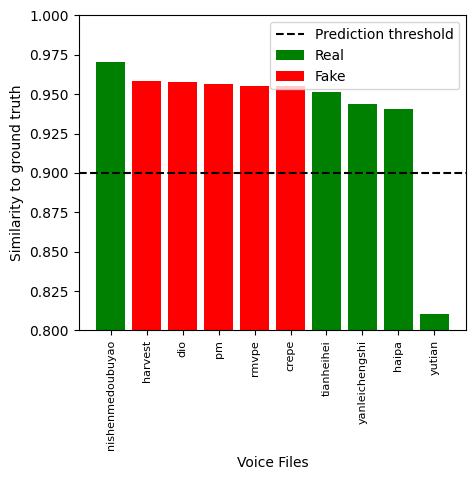

In [3]:
# DEMO 05: In this demo we'll show how we can achieve a modest form of fake speech detection with 
# Resemblyzer. This method assumes you have some reference audio for the target speaker that you 
# know is real, so it is not a universal fake speech detector on its own.
# In the audio data directory we have 18 segments of Donald Trump. 12 are real and extracted from
# actual speeches, while the remaining 6 others are fake and generated by various users on 
# youtube, with a high discrepancy of voice cloning quality and naturalness achieved. We will 
# take 6 segments of real speech as ground truth reference and compare those against the 12 
# remaining. Those segments are selected at random, so will run into different results every time
# you run the script, but they should be more or less consistent.
# Using the voice of Donald Trump is merely a matter of convenience, as several fake speeches 
# with his voice were already put up on youtube. This choice was not politically motivated.


## Load and preprocess the audio
# data_dir = Path("audio_data", "donald_trump")
# wav_fpaths = list(data_dir.glob("**/*.mp3"))
data_dir = Path("audio_data", "sun_real_fake")
wav_fpaths = list(data_dir.glob("**/*.*"))
wavs = [preprocess_wav(wav_fpath) for wav_fpath in \
        tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit=" utterances")]


## Compute the embeddings
encoder = VoiceEncoder()
embeds = np.array([encoder.embed_utterance(wav) for wav in wavs])
speakers = np.array([fpath.parent.name for fpath in wav_fpaths])
names = np.array([fpath.stem for fpath in wav_fpaths])


# Take 6 real embeddings at random, and leave the 6 others for testing
gt_indices = np.random.choice(*np.where(speakers == "real"), 5, replace=False) 
mask = np.zeros(len(embeds), dtype=bool)
mask[gt_indices] = True
gt_embeds = embeds[mask]
gt_names = names[mask]
gt_speakers = speakers[mask]
embeds, speakers, names = embeds[~mask], speakers[~mask], names[~mask]


## Compare all embeddings against the ground truth embeddings, and compute the average similarities.
scores = (gt_embeds @ embeds.T).mean(axis=0)

# Order the scores by decreasing order
sort = np.argsort(scores)[::-1]
scores, names, speakers = scores[sort], names[sort], speakers[sort]


## Plot the scores
# fig, _ = plt.subplots(figsize=(6, 6))
fig, _ = plt.subplots(figsize=(5, 5))
indices = np.arange(len(scores))
plt.axhline(0.9, ls="dashed", label="Prediction threshold", c="black")
plt.bar(indices[speakers == "real"], scores[speakers == "real"], color="green", label="Real")
plt.bar(indices[speakers == "fake"], scores[speakers == "fake"], color="red", label="Fake")
plt.legend()
plt.xticks(indices, names, rotation="vertical", fontsize=8)
plt.xlabel("Voice Files")
plt.ylim(0.8, 1)
plt.ylabel("Similarity to ground truth")
fig.subplots_adjust(bottom=0.25)
plt.show()


# Demo 4: Speaker Naturness

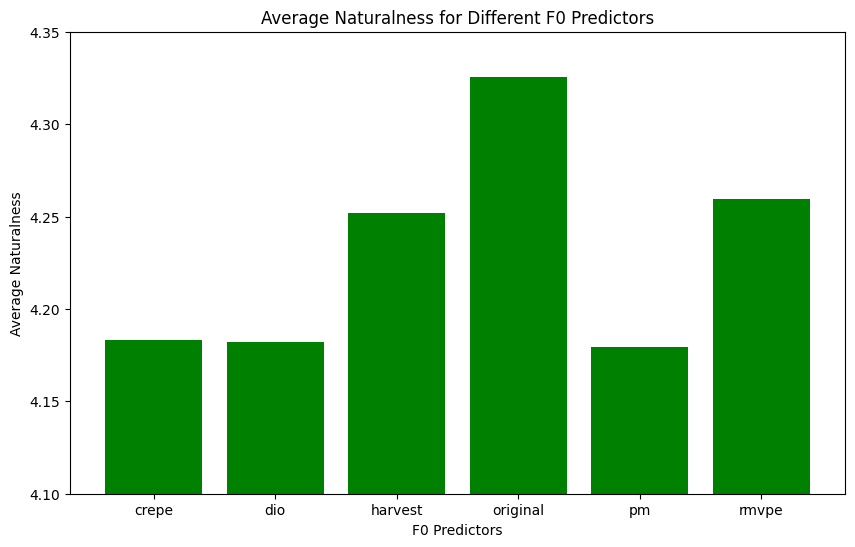

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read all CSV files and calculate the average MOS for each vcoder
results_dir = './audio_data/results'
vcoders = set()

# Dictionary to store average MOS for each vcoder
average_mos = {}

for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file.endswith('NISQA_results.csv'):
            # print(root)
            vcoder = root.split('\\')[1]  # Extract vcoder name from the file path
            vcoders.add(vcoder)
            
            # Read CSV file
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path)
            
            # Calculate average MOS for each vcoder
            avg_mos = df['mos_pred'].mean()
            
            # Store in the dictionary
            if vcoder in average_mos:
                average_mos[vcoder].append(avg_mos)
            else:
                average_mos[vcoder] = [avg_mos]

keys = list(average_mos.keys())
values = [value[0] for value in average_mos.values()]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='green')
plt.xlabel('F0 Predictors')
plt.ylabel('Average Naturalness')
plt.title('Average Naturalness for Different F0 Predictors')
plt.ylim(4.1, 4.35)  # Set y-axis limits if needed

# Display the plot
plt.show()
